# QC on WaferGen PCR SmartChip


## Get Data

In [1]:
import pandas, os, glob
import logging
import matplotlib.pyplot as plt
import seaborn 
%matplotlib inline
FORMAT = "%(asctime)s:%(levelname)s:%(message)s"
logging.basicConfig(format=FORMAT)
LOG= logging.getLogger()
LOG.setLevel(logging.DEBUG)


seaborn.set_style(style='white')

class FilePaths():
    def __init__(self):
        self.dire =  r'/home/b3053674/Documents/Miscellaneous/WaferGenAnalysis'
#         self.dire=r'C:\Users\Ciaran\Documents\Miscellaneous\WaferGenAnalysis'
        self.ncl = os.path.join(self.dire, 'GSS2242_NCGeneSet')
        self.ecm = os.path.join(self.dire, 'GSS2266_ECMGeneSet')
        self.ncl_raw_data_files = sorted(glob.glob(os.path.join(self.ncl, '*WellData*')  )  )
        self.ecm_raw_data_files = sorted(glob.glob(os.path.join(self.ecm, '*WellData*')  )  )
        self.QC = os.path.join(self.dire, 'QCResults')
        
        self._make_qc()
        
    def _make_qc(self):
        """
        
        """
        if os.path.isdir(self.QC)!=True:
            os.mkdir(self.QC)


F=FilePaths()

def parse_data(data1, data2, labels1, labels2):
    """
    Parse smart-chip PCR data
    
    args:
        data1: data from chip 1 (NCL or ECM)
    
        data2 Data from chip2 (NCL or ECM)
        
        labels1: labels for chips (NCL or ECM)
        
        labels2: Condition labels (Neonatal, IR and Adult)
    
    """

    ## construct python dict for data
    dct = {}
    for i in range(len(labels1)):
        dct[labels1[i]] = {}

    for i in range(len(labels1)):
        for j in range(len(labels2)):
            if labels1[i]=='Chip1NCL':
                dct[labels1[i]][labels2[j]] = pandas.read_csv(data1[j], sep='\t')
            elif labels1[i]=='Chip2ECM':
                dct[labels1[i]][labels2[j]] = pandas.read_csv(data2[j], sep='\t')

    ## remove unwanted columns
    columns = ['Assay', 'Sample','Ct']
    dct2 = {}
    for chip in dct:
        dct2[chip] = {}
        for treatment in dct[chip]:
            dct2[chip][treatment] = dct[chip][treatment][columns]
            
    ## parse data into one pandas dataframe

    df_dct = {}
    for chip in dct2:
        df_dct[chip] = pandas.concat(dct2[chip])
        
    return pandas.concat(df_dct)

    
ncl_raw_data = sorted(glob.glob(os.path.join(F.ncl, '*WellData*')  )  )
ecm_raw_data = sorted(glob.glob(os.path.join(F.ecm, '*WellData*')  )  )

labels1 = ['Chip1NCL', 'Chip2ECM']
labels2 = ['Neonatal', 'IR', 'Adult']
    
    
LOG.info('Parsing data from file into python ')
df = parse_data(F.ncl_raw_data_files, F.ecm_raw_data_files, labels1, labels2)




def format_data(df):
    """
    Make data look pretty
    """
    LOG.debug('DataFrame now looks like this:\n{}'.format(df.head()) )
    df=df.reset_index()
    df=df.drop('level_2', axis=1)
    df.columns = ['Chip', 'CellType', 'Gene', 'Sample', 'Ct']
    # df4=df3.set_index(['Chip','CellType','Gene','Sample'])
    df = df.dropna()
    return df




def index_df(data):
    """
    Index the specific dataframe what we are working with. 
    
    This is useful as a function because when using juptyer notebook if you 
    try and run a section of script more than once you'll get an error. 
    Instead use this function within other functions to locally index the data. 
    """
    ## Index the data
    sample_id = list(data['Sample'])
    treat, time, repeat = zip(*[i.split('_') for i in sample_id])
    data['Time'] = [int(i) for i in time]
    data['Repeat'] = [int(i) for i in repeat]
    
    data = data.set_index(['Chip', 'CellType', 'Gene', 'Repeat', 'Time'])
    data=data.drop('Sample', axis=1)
    data = data.sort_index(level=[0,1,2,3])
    return data




df = format_data(df)

2017-07-13 15:57:09,985:INFO:Parsing data from file into python 
2017-07-13 15:57:10,095:DEBUG:DataFrame now looks like this:
                   Assay     Sample        Ct
Chip1NCL Adult 0    ABL1  Tgfb_48_4  23.98787
               1    ACTB  Tgfb_48_4  21.11110
               2   CDC42  Tgfb_48_4  24.20522
               3  CDKN2A  Tgfb_48_4  28.10812
               4   NFKB2  Tgfb_48_4  28.18900



## Plot some graphs that serve as QC

2017-07-13 15:57:10,259:DEBUG:Saving to /home/b3053674/Documents/Miscellaneous/WaferGenAnalysis/QCResults/RawCtDistributionsPerChipPerCellType.png


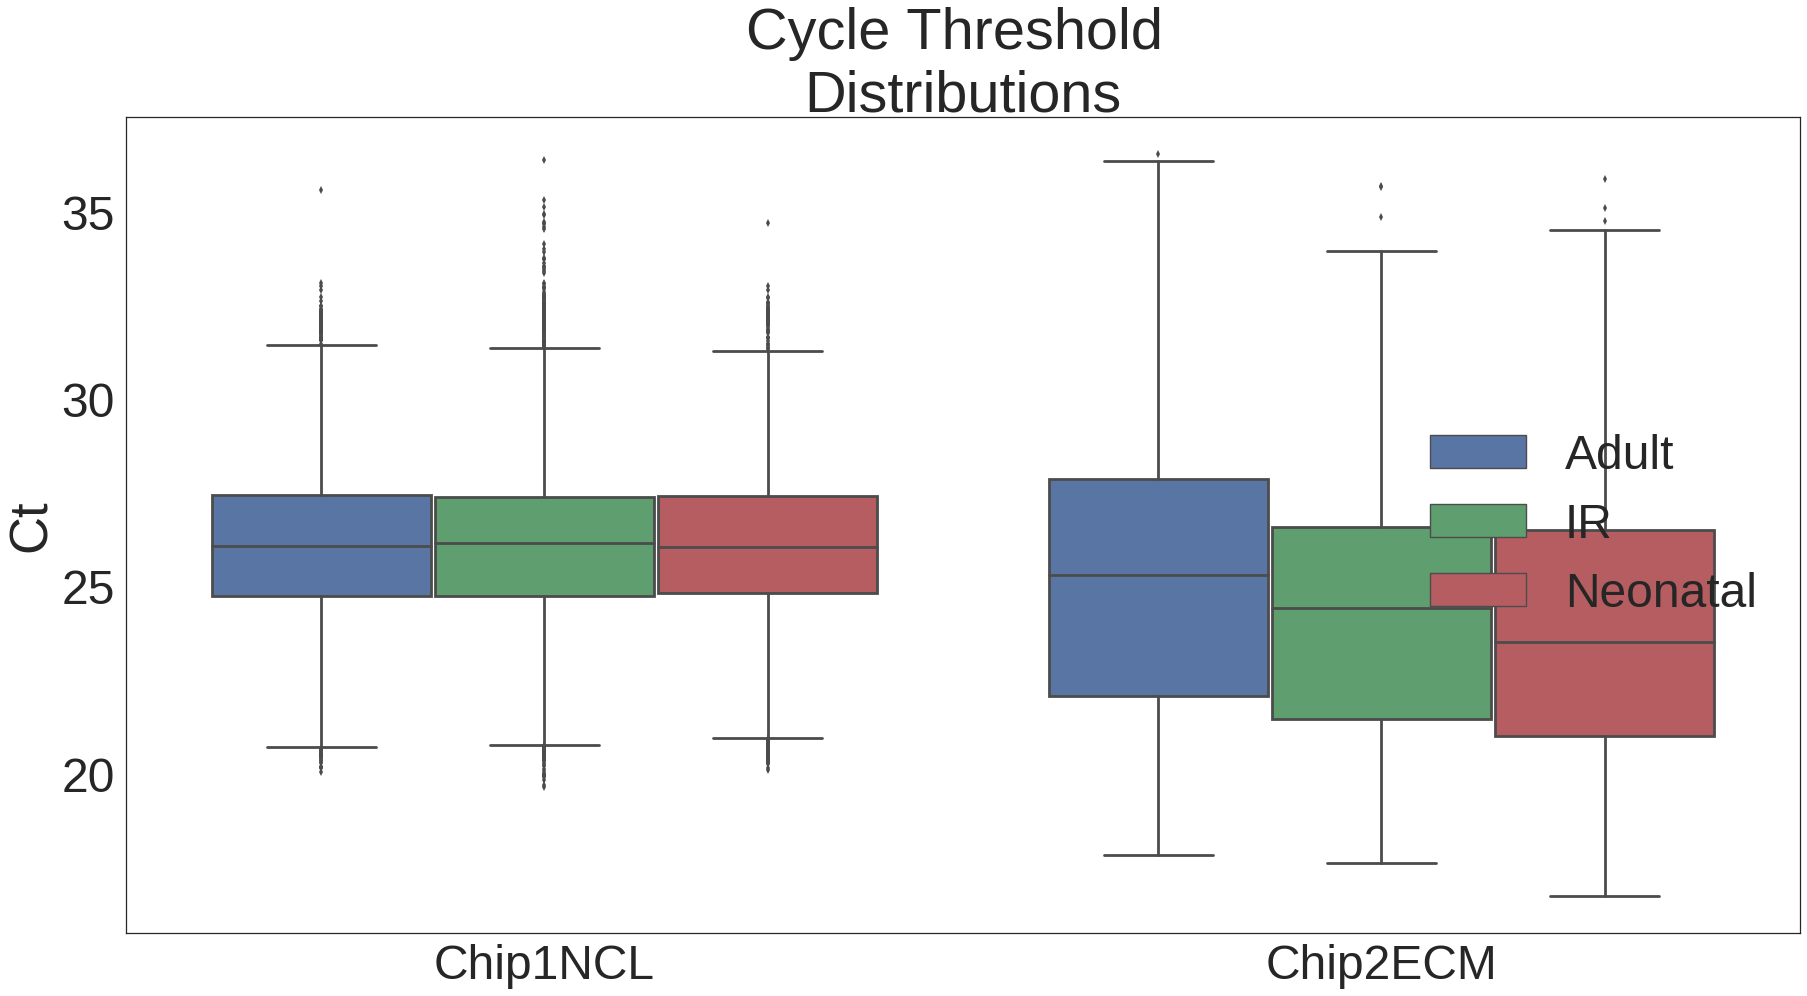

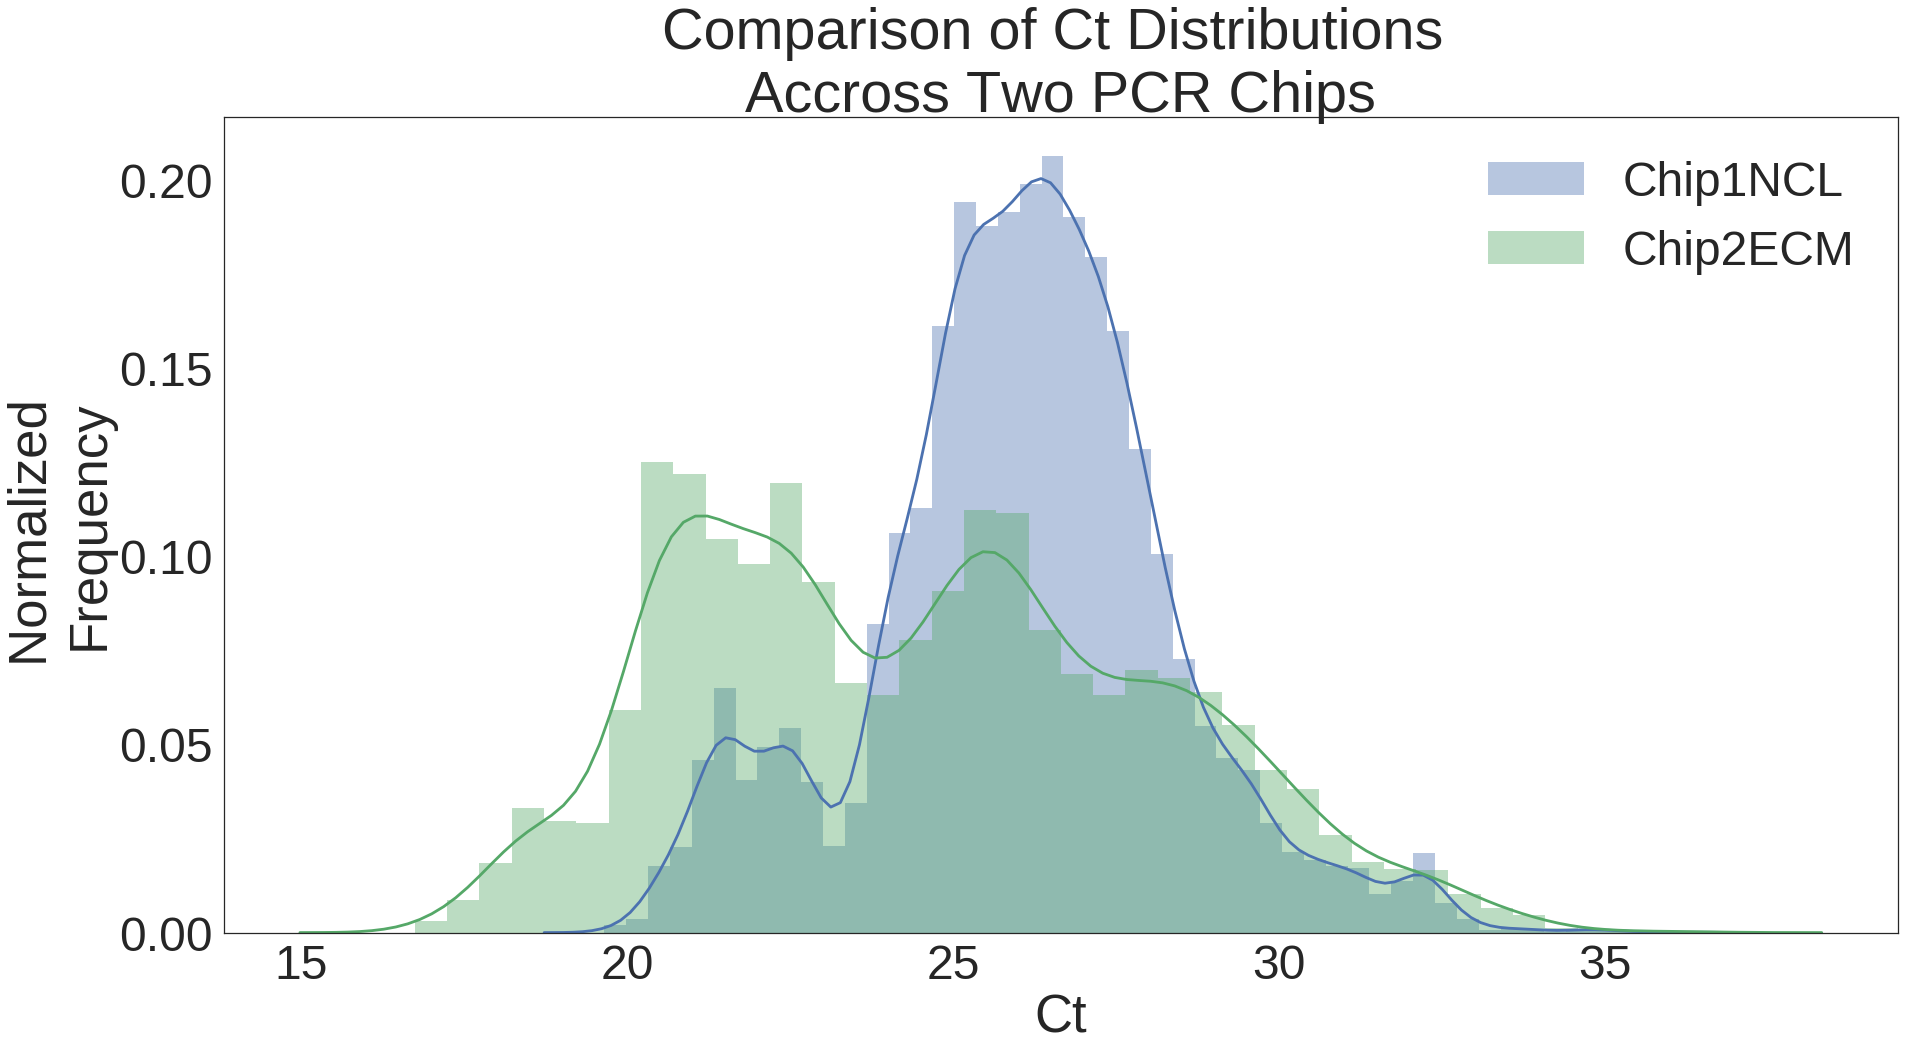

In [2]:
seaborn.set_context(context='poster', font_scale=3)

SAVE = True

PLOT_CYCLE_THRESHOLD_DISTRIBUTIONS = True
PLOT_DENSITY = True




if PLOT_CYCLE_THRESHOLD_DISTRIBUTIONS:
    
    plt.figure(figsize=(30,15))
    ax = seaborn.boxplot(data=df, x='Chip', y='Ct', hue='CellType')
    plt.title('Cycle Threshold \nDistributions')
    ax.set(xlabel='')
#     plt.legend(loc=(0.3,-0.7))
    plt.legend(loc='best')

    if SAVE:
        fle = os.path.join(F.QC, 'RawCtDistributionsPerChipPerCellType.png')
        LOG.debug('Saving to {}'.format(fle))
        plt.savefig(fle, bbox_inches='tight', dpi=300)
        
if PLOT_DENSITY:
    plt.figure(figsize=(30,15))
    for label, d in df.groupby(by='Chip'):
        seaborn.distplot(d['Ct'], label=label)
#         plt.legend(loc=(0.2,-0.65))
        plt.legend(loc='best')

        plt.title('Comparison of Ct Distributions \nAccross Two PCR Chips')
        plt.ylabel('Normalized \nFrequency')
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'DensityPlotCtDistributions.png'), bbox_inches='tight', dpi=300)


# PCA

2017-07-13 15:57:39,690:DEBUG:Formatting Data for PCA
2017-07-13 15:57:39,730:DEBUG:df_indexed now looks like this:
                                            Ct
Chip     CellType Gene   Repeat Time          
Chip1NCL Adult    ABL1   4      48    23.98787
                  ACTB   4      48    21.11110
                  CDC42  4      48    24.20522
                  CDKN2A 4      48    28.10812
                  NFKB2  4      48    28.18900
2017-07-13 15:57:39,742:DEBUG:Performing imputation for missing values


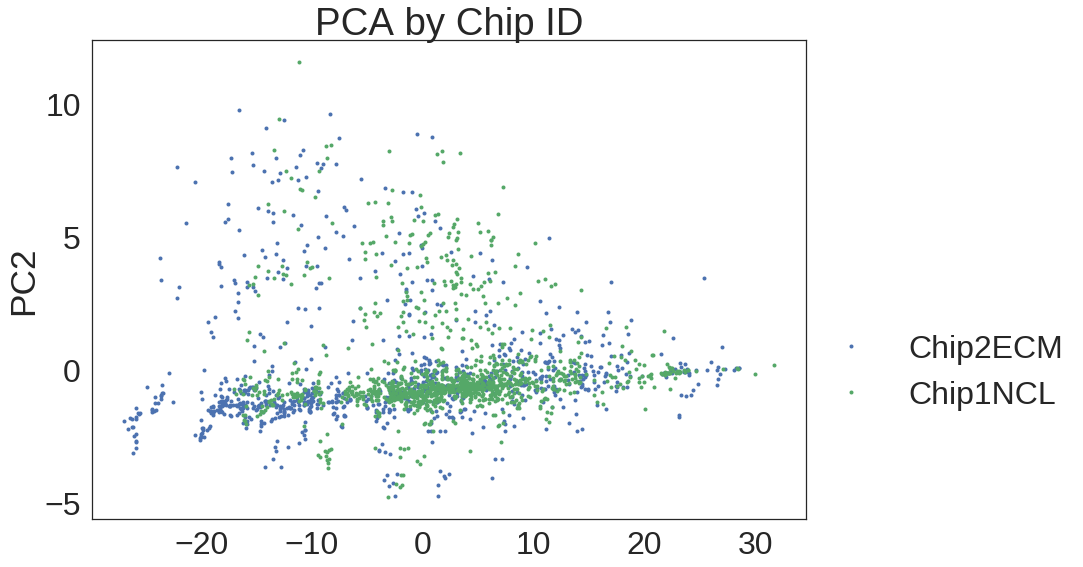

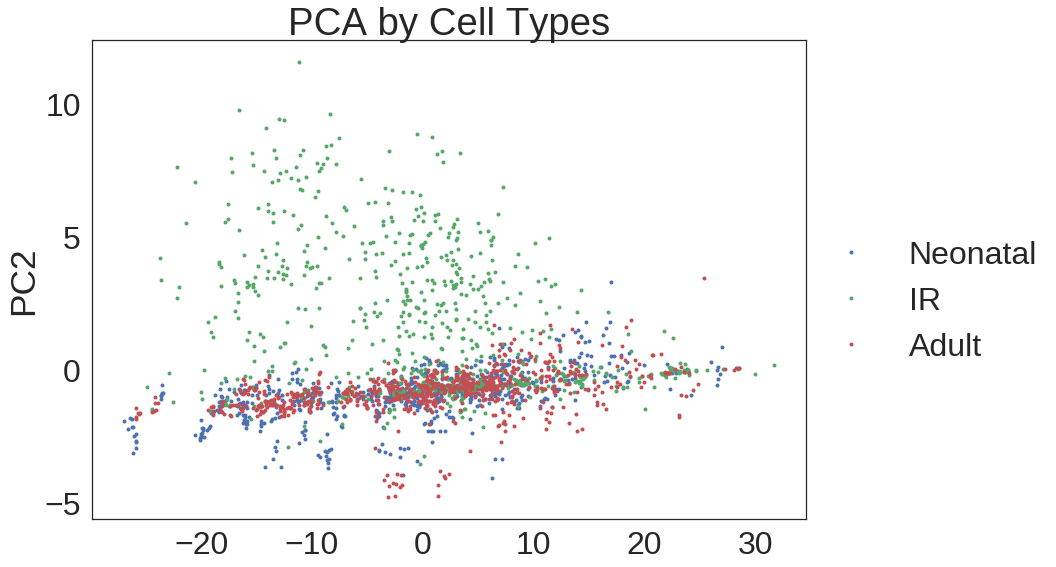

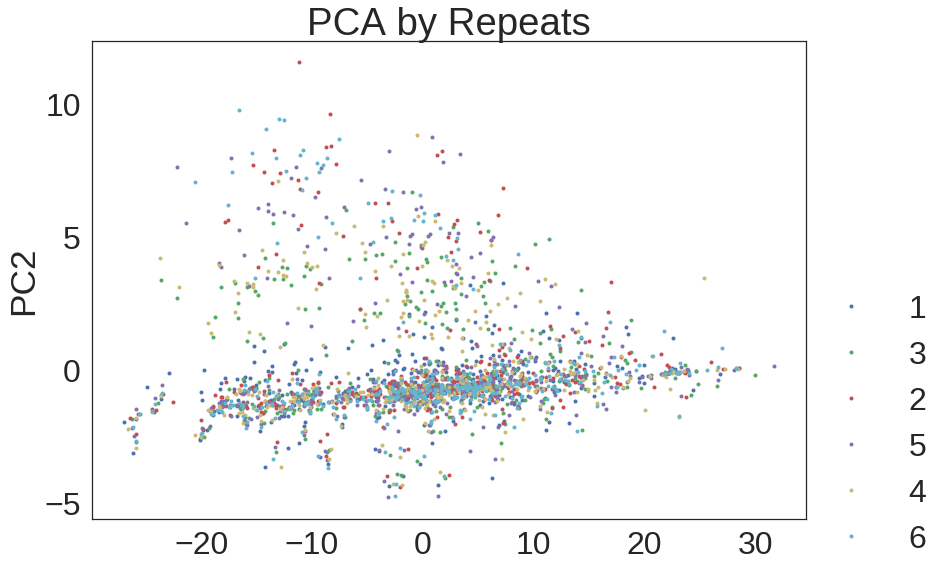

In [3]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib
from pylab import legend

PLOT_EXPLAINED_VARIANCE_RATIO = False
SAVE=True
PLOT_PCA = True
# df_indexed = df.set_index(['Chip', 'CellType', 'Gene', 'Sample'])

def plot_pca(df, hue, PLOT_EXPLAINED_VARIANCE_RATIO=False, SAVE=False, PLOT_PCA=True,ms=2):
    """
    """
    seaborn.set_context(context='poster', font_scale=2)
    ## format split samples column by '_' to get more detailed index
    LOG.debug('Formatting Data for PCA')
    sample_ids = list(df['Sample'])
    sample_ids = [i.split('_') for i in sample_ids]
    treat, time, repeat =  zip(*sample_ids)  
    df_indexed = df.copy()
    df_indexed['Time'] = time
    df_indexed['Repeat'] = repeat

    df_indexed  = df_indexed.set_index(['Chip','CellType','Gene','Repeat','Time'])
    df_indexed = df_indexed.drop('Sample', axis=1)
    LOG.debug('df_indexed now looks like this:\n{}'.format(df_indexed.head()))

    df_indexed =df_indexed.unstack()
    
    df_indexed.columns = df_indexed.columns.droplevel(0)
    
    
    
    seaborn.color_palette("hls", 24)


    ##imputation with median prior to feeding into PCA
    LOG.debug('Performing imputation for missing values')
    imp =preprocessing.Imputer(strategy='median', axis=1)
    imp.fit(df_indexed)
    df_imputed = (imp.transform(df_indexed))
    df_imputed = pandas.DataFrame(df_imputed, columns=df_indexed.columns, index =df_indexed.index ) 
    df_imputed = df_imputed[sorted(df_imputed.keys())]
    
    if PLOT_EXPLAINED_VARIANCE_RATIO :
        
        pca = PCA(n_components=10)
        pca = pca.fit(df_imputed)
        plt.figure()
        plt.title('Explained Variance Ratio for First \n 10 Principle Components')
        var_ratio = pca.explained_variance_ratio_
        plt.plot(range(len(var_ratio)), var_ratio)
        plt.ylabel('Explained Variance\n Ratio')
        plt.xlabel('Principle Component')
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'ExplainedVarianceRatioPlot.png'), bbox_inches='tight', dpi=300)
        

    if PLOT_PCA:
        
        BY_CHIP = True
        BY_CELL_TYPE = True
        BY_REPEAT = True

        pca = PCA(n_components=2)
        pca = pca.fit(df_imputed)
        pca_df = pandas.DataFrame(pca.transform(df_imputed), index=df_imputed.index) 

        if BY_CHIP:
            hue = list(set(pca_df.index.get_level_values(0)))
            plt.figure()
            for i in range(len(hue)):# set(list(pca_df.index.get_level_values(0))):
                plt.title('PCA by Chip ID')
                pl = plt.plot(pca_df.loc[hue[i]][0], pca_df.loc[hue[i]][1],'o',label=hue[i],markersize=ms)
                
#                 plt.xlabel('PC1')
                plt.ylabel('PC2')
#                 plt.legend(bbox_to_anchor=(0.3, -0.5, 1, -1), loc=8,
#                            ncol=3, mode="expand", borderaxespad=-1)
                plt.legend(loc=(1, 0.2))
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'PCAByChipID.png'), bbox_inches='tight', dpi=300)

        if BY_CELL_TYPE:
            hue = list(set(pca_df.index.get_level_values(1)))
            pca_df_cell_type = pca_df.reorder_levels([1,0,2,3])
#             print(pca_df_cell_type)
            plt.figure()
            for i in range(len(hue)):
                plt.title('PCA by Cell Types')
                plt.plot(pca_df_cell_type.loc[hue[i]][0], pca_df_cell_type.loc[hue[i]][1],
                        'o', label=hue[i],markersize=ms)
#                 plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.legend(loc=(1,0.3))
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'PCAByCellType.png'), bbox_inches='tight', dpi=300)


        if BY_REPEAT:
            hue = list(set(pca_df.index.get_level_values(3)))
            pca_df_repeat = pca_df.reorder_levels([3,1,2,0])
            plt.figure()
            for i in range(len(hue)):
                plt.title('PCA by Repeats')
                plt.plot(pca_df_repeat.loc[hue[i]][0], pca_df_repeat.loc[hue[i]][1],
                        'o', label=hue[i], markersize=ms)
#                 plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.legend(loc=(1,-0.1))
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'PCAByRepeat.png'), bbox_inches='tight', dpi=300)


        # pca.fit(df_indexed)/

plot_pca(df, 0, ms=4, SAVE=True)

# Normalization to Reference Genes 
## First Calculate Geometric Mean of Reference Genes

In [4]:
from scipy.stats.mstats import gmean


    
    

def geometric_mean(data, reference_genes):
    """
    Compute the geometric mean of the reference genes. 
    Geometric mean is computer per chip, per cell type and per repeat
    before any averaging has taken place. 
    
    args:
        data. Pandas dataframe containing wafergen data. 
        
    reference_genes:
        list of genes to include as reference genes
        
        
        
    Sanity Check:
        Manual computation to be sure I get the right answer:
        Chip2ECM:
            Adult:
                ACTB Repeat 1 Time 0:
                    21.77451
                B2M Repeat 1 Time 0:
                    21.57830
                GAPDH Repeat 1 Time 0:
                    20.46535
                PPIA Repeat 1 Time 0:
                    22.43597
        >>> print (gmean([21.77451, 21.57830,20.46535, 22.43597 ]))
        Answer:
            21.5517435742
    
    
    """
    ##index frame 
    
    data = index_df(data)

    ## we do normalization per cell type per chip
    df_dct = {}
    for label, df in data.groupby(level=[0,1]):
        ## get reference genes
        ref = df.loc[label+(reference_genes,)]
        ref = ref.unstack()
        ref.columns = ref.columns.droplevel(0)
        ## calculate geomean
        geomean = ref.groupby(level=3).aggregate(gmean)
        geomean.columns = ref.columns
        df_dct[label] = geomean
        
    ## Concatonate into one frame
    ref =pandas.concat(df_dct)
    
    ## "Hard Calculate" the geomean for one value for sanity check (see doc)
    sanity_check = 21.5517435742
    
    LOG.info('Checking sanity... Passed== {}'.format(round(sanity_check, 10) == round(ref.loc['Chip1NCL', 'Adult', 1][0], 10) ))
    
    return ref

        
ref =  geometric_mean(df, ['ACTB', 'B2M', 'GAPDH','PPIA' ]) 


2017-07-13 15:57:49,338:INFO:Checking sanity... Passed== True


In [5]:


def do_normalization(data, reference_data):
    """
    
    
    
    
    Sanity check:
        ncl_adult_abl1 = data.loc['Chip1NCL','Adult', 'ABL1',1]
        ncl_adult_geomean1 = reference_data.loc['Chip1NCL','Adult',1]

        >>> print(2**-(ncl_adult_abl1 - ncl_adult_geomean1))
        Time
        0     0.378423
        1     0.248551
        2     0.179178
        4     0.150038
        8     0.334396
        12    0.178134
        18    0.231421
        24    0.228952
        30    0.205568
        36    0.191330
        42    0.211114
        48    0.204047
        dtype: float64
    
    """
    data = index_df(data)
    data = data.unstack()
    data.columns = data.columns.droplevel(level=0)
    LOG.debug('data.shape is: {}, reference_data.shape is {}'.format(data.shape, reference_data.shape))
    
    df_dct = {}
    for label, df in data.groupby(level=[0,1,2]):
        df_dct[label] = 2**-(df.loc[label] - reference_data.loc[label[0], label[1]] )
    df =  pandas.concat(df_dct)
    return df
    
normed_df = do_normalization(df, ref)
print(normed_df)

2017-07-13 15:57:49,422:DEBUG:data.shape is: (2176, 12), reference_data.shape is (36, 12)


Time                                   0          1         2          4   \
                        Repeat                                              
Chip1NCL Adult    ABL1  1        0.378423   0.248551  0.179178   0.150038   
                        2        0.252881   0.279559  0.213601   0.199234   
                        3        0.236720   0.260313  0.348345   0.204861   
                        4        0.349686   0.321212  0.252863   0.177351   
                        5        0.246072   0.224094  0.199134   0.149343   
                        6        0.218976   0.220621  0.266195   0.177691   
                  ACTA2 1        0.041949   0.029644  0.038330   0.055325   
                        2        0.037232   0.031133  0.032281   0.069080   
                        3        0.048185   0.038940  0.034083   0.053246   
                        4        0.045904   0.036322  0.040444   0.036736   
                        5        0.055087   0.051550  0.043652   0.036175   

### Probe the normed_df in various places so ensure its done correctly

In [6]:
def checker(data, reference_data, normed_df, index0='Chip1NCL', index1='Adult', index2='ABL1', index3=1):
    """
    Check that the normalization has been done correctly
    
    Ensure index2 refers to a gene which is actually on the chip
    
    args:
        data:
             Original frame with raw ct values
        
        reference_data:
            Data being used as reference data. In this ipynb its the geometric mean of the four housekeeping genes
            
        normed_df:
            Normalized data calculated by do_normalization
            
    kwargs:
        index0:
            string. Either 'Chip1NCL' (default) or 'Chip2ECM'
            
        index1:
            string. Either 'Adult' (default), 'Neonatal' or 'IR'
            
        index2: 
            string: Default='ABL1'. Name of gene to test. The two chips have different gene sets and this 
            gene must be in the index0
            
        index3:
            int. repeat index. defualt=1. In 1,2,3,4,5,6
        
    
    """
    ## index and unstack data
    data = index_df(data)
    data = data.unstack()
    data.columns = data.columns.droplevel(level=0)
    
    LOG.debug('index0: {}, index1: {}, index2: {}, index3: {}'.format(index0, index1, index2, index3))
    data = (data.loc[index0, index1, index2, index3])
    ##swap level
    normed_data = (normed_df.loc[index0, index1, index2])
    ref = reference_data.loc[index0, index1, index3]
    
    res = 2**-(data-ref) == normed_data.loc[index3] 
#     LOG.debug('manually computed:\n{}, Computed in function: \n{}'.format(res ) )
    LOG.info('Checking that manually computed normalization is the same as that computed in the do_normalization function\n{}'.format(res))
    return res



checker(df, ref, normed_df, index0='Chip2ECM', index1 = 'IR', index2='COL1A2', index3=4)
checker(df, ref, normed_df, index0='Chip2ECM', index1 = 'Neonatal', index2='COL1A2', index3=4)
checker(df, ref, normed_df, index0='Chip1NCL', index1 = 'Adult', index2='SMURF1', index3=4)

##happy

2017-07-13 15:57:50,390:DEBUG:index0: Chip2ECM, index1: IR, index2: COL1A2, index3: 4
2017-07-13 15:57:50,395:INFO:Checking that manually computed normalization is the same as that computed in the do_normalization function
Time
0     True
1     True
2     True
4     True
8     True
12    True
18    True
24    True
30    True
36    True
42    True
48    True
dtype: bool
2017-07-13 15:57:50,461:DEBUG:index0: Chip2ECM, index1: Neonatal, index2: COL1A2, index3: 4
2017-07-13 15:57:50,467:INFO:Checking that manually computed normalization is the same as that computed in the do_normalization function
Time
0     True
1     True
2     True
4     True
8     True
12    True
18    True
24    True
30    True
36    True
42    True
48    True
dtype: bool
2017-07-13 15:57:50,591:DEBUG:index0: Chip1NCL, index1: Adult, index2: SMURF1, index3: 4
2017-07-13 15:57:50,598:INFO:Checking that manually computed normalization is the same as that computed in the do_normalization function
Time
0     True
1     Tr

Time
0     True
1     True
2     True
4     True
8     True
12    True
18    True
24    True
30    True
36    True
42    True
48    True
dtype: bool

In [ ]:

SAVE=True

seaborn.set_context(context='poster', font_scale=6)
stacked = normed_df.stack()
stacked = stacked.reset_index()
stacked.columns = ['Chip', 'CellType', 'Gene','Repeat','Time','2^deltaCt']
    
fig = plt.figure(figsize=(60,15))


# fig = plt.figure(figsize=(30,15))
fig.add_subplot(1,3,1)
ax = seaborn.boxplot(data=stacked, x='Chip', y='2^deltaCt', hue='CellType')
#     plt.title('Distribution of Cycle Thresholds Accross \nChips and Cell Lines')
ax.set(xlabel='')
plt.legend(loc='best')
# if SAVE:
#     plt.savefig(os.path.join(F.QC, '2deltaCtBoxplots.png'), bbox_inches='tight', dpi=300)





for label, df in stacked.groupby(by='Chip'):
    ax1 = fig.add_subplot(132)
    seaborn.distplot(df['2^deltaCt'], label=label)
    plt.legend(loc='best')
    ax1.set_xlabel('')

for label, df in stacked.groupby(by='CellType'):
    ax2 = fig.add_subplot(133)
    seaborn.distplot(df['2^deltaCt'], label=label)
    plt.legend(loc='best')
    ax2.set_xlabel('')


#     for label, df in stacked.groupby(by='Repeat'):
#         ax3 = fig.add_subplot(2,2,3)
#         seaborn.distplot(df['2^deltaCt'], label=str(label))
#         plt.legend(loc='best')
#         ax3.set_xlabel('')

    plt.tight_layout()
    
    plt.suptitle('Distribution of Normalized Cycle Thresholds Accross Chips and Cell Lines')
    plt.subplots_adjust(top=0.85)
    
if SAVE:
    plt.savefig(os.path.join(F.QC, 'DistributionsOfNormalizedCtValues.png'), bbox_inches='tight', dpi=300)
            
            
            

## build way of removing data points